<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3ba_pruning_llama_instruct_optipfair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1>Large Language Models Projects</a></h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>Width Pruning Llama 3.2. with OptiPFair (Adapted to Instruct models)</h2>
    <h3>Using OptiPFair to prune MLP Layers with GLU structure.</h3>
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)

________
Models: meta-llama/Llama-3.2-1B

Colab Environment: GPU T4.

Keys:
* Pruning
* Structured pruning
* optiPfair

_______
<table style="border: none; background: none;">
  <tr style="border: none;">
    <td style="border: none; vertical-align: middle; width: 120px;">
      <a href="https://hubs.la/Q040tvsK0">
        <img src="https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/Images/cover.png" width="110" style="border-radius: 4px;">
      </a>
    </td>
    <td style="border: none; vertical-align: middle;">
      <h2 style="margin: 0;">The Evolution of LLM Pruning</h2>
      <p style="margin: 5px 0;">Whant to know more? check <strong>"Rearchitecting LLMs"</strong> (Manning Publications).</p>
      <p>
        <a href="https://hubs.la/Q040tvsK0"><strong>Check the MEAP</strong></a>
      </p>
    </td>
  </tr>
</table>

______

# Introduction
This notebook cotinues the work done at: [6_3_pruning_structured_llama3.2-1b_OK.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3_pruning_structured_llama3.2-1b_OK.ipynb) the pruning process was done manually, and you can find the implementation code there. In this notebook, we use the [OptiPFair](https://github.com/peremartra/optipfair) library, developed by myself, which simplifies the pruning process for LLMs.

En este notebook nos focalizamo en explicar el funcionamiento de la libreria OptiPFair y sus diversas opciones para realizar el pruning de las capas MLP de modelos con estructura GLU: Llama, Gemma, QWen, Mistral y otros.


#Install libraries & Configure variables.

In [1]:
!pip install -q transformers
!pip install -q optipfair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.3 MB/s eta 0:00:00


In [2]:
pip show optipfair

Name: optipfair
Version: 0.1.5
Summary: A library for structured pruning & Bias visualization of large language models
Home-page: https://github.com/peremartra/optipfair
Author: Pere Martra
Author-email: peremartra@uadla.com
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: click, torch, tqdm, transformers
Required-by: 


In [3]:
import torch
import os

from tqdm import tqdm
from optipfair import prune_model
from transformers import AutoModelForCausalLM, AutoTokenizer

In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#Download model and explore structure

In [ ]:
model_name = 'meta-llama/Llama-3.2-1B-Instruct'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
#tokenizer.pad_token = tokenizer.eos_token  # Set pad token

In [6]:
def get_output(prompt, model=model, tokenizer=tokenizer):
    # Chat forma for modelInstruct
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Aply chat template
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors='pt'
    ).to(device)

    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        temperature=None,
        top_p=None,
        do_sample=False,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    generated_tokens = outputs[0][len(inputs[0]):]
    generated = tokenizer.decode(generated_tokens, skip_special_tokens=True)


    return generated.strip()

## studying the model structure
As demonstrated in the [previous notebook](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb), studying the structure of the model that will undergo pruning is crucial.

In this notebook, we’re going to fine-tune the pruning process for the Llama3.2 model.

In [7]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro


An MLP block typically consists of layers that scale the data to larger dimensions and others that return it to its original size.

In the MLP block of the model, we find two projection layers: `gat_proj` and `down_proj`, both scaling from 2048 to 8192. The purpose of having two layers projecting to the same intermediate size might be related to gating mechanisms. A gating mechanism selectively controls information flow in neural networks by using learned weights to "gate" or filter inputs.

However, to truly understand how these layers function, we’d need to refer to the model's documentation or even the source code. But, this structure usually indicates, at least, I haven't encountered a case where it doesn't, that the layers performing the upsizing work in pairs, and they cannot be treated as independent linear layers.

In other words, any operation we apply to one layer must be replicated in the other. Most importantly, when identifying which neurons have more or less importance, we can't evaluate the neurons of a single layer in isolation; we need to treat them as pairs.



In [8]:
# Test the original model
prompt = "What is the capital of France?"
generated = get_output(prompt)
print(f"Generated text: {generated}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text: Paris is not only a city in France, but it's also the country's capital. It's a beautiful and iconic city known for its stunning architecture, art museums, fashion, and cuisine.


#Pruning the Model.
##Support pruning functions.
###Compute neuron importance functions.

To perform the pruning process, you need to call the `prune_model` function from the library (OptiPFair)[https://github.com/peremartra/optipfair].

To use this function, you need to provide the following parameters:

* model: The model to be pruned.
* pruning_type: The type of pruning to apply. In this case, it will be "MLP_GLU", which is currently the only option supported by the library.
* neuron_selection_method:
  * MAW: Maximum Absolute Weight Values.
  * VOW: Variance Of Weigths.
  * PON: Product Of Norms.
  With LLaMA models, the method that works best without requiring further training is MAW.
* pruning_percentage o expansion_rate: you need to provide one of them. In this notebook, we’ll use pruning_percentage.
* show_progress: By default, it's set to True. It displays the progress of the pruning process.
* return_stats: By default, it's set to True. It returns the percentage of neurons removed and the resulting expansion rate.


*I’m leaving the others in the notebook purely as an exercise.*

The **MAW** method works better because it directly identifies the most influential neurons based on the magnitude of their connections. These neurons are likely responsible for key decisions, making the model more accurate after pruning. The Variance of Weights method, while useful in some contexts, can retain neurons that may not contribute significantly to the task, leading to less coherent model outputs.

However, we shouldn’t fall into the trap of assuming that this neuron selection method will work best across all model structures. It works well with Llama models, and this may be due to several factors:

* The relatively large projection from 2048 to 8192.
* The use of a GLU structure.
* The type of activation function used.

So, if we use a model from another family, like Gemma or Mistral, the neuron selection method might need to be entirely different.

## Obtain & test the pruned model.

In [9]:
# Prune 10% of neurons from MLP layers using MAW method
pruned_model, stats = prune_model(
    model=model,
    pruning_type="MLP_GLU",
    neuron_selection_method="MAW",
    pruning_percentage=20,
    show_progress=True,
    return_stats=True
)

Pruning layers: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


In [10]:
# Print pruning statistics
print(f"Original parameters: {stats['original_parameters']:,}")
print(f"Pruned parameters: {stats['pruned_parameters']:,}")
print(f"Reduction: {stats['reduction']:,} parameters ({stats['percentage_reduction']:.2f}%)")
print(f"Expansion rate: {stats['expansion_rate']:,}%")


Original parameters: 1,235,814,400
Pruned parameters: 1,074,792,448
Reduction: 161,021,952 parameters (13.03%)
Expansion rate: 320.01953125%


In [11]:
# prompt: call the generate_response for the pruned_model

prompt = "What is the capital of France?"
generated = get_output(prompt)
print(f"Generated text: {generated}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generated text: Yes, it is Paris.


The result is slightly different from what the original model produced, but it’s still a fairly accurate response.

In contrast to the model created in notebook: [6_2_pruning_structured_llama3.2-1b_KO.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb) where the pruned Llama model lost almost all its utility, the model in this notebook retains a good portion of its knowledge.

Looking at the model’s new structure, we can see that the `gate_proj` and `up_proj` layers have had their `out_features` reduced to 6554 from 8192. Consequently, the `down_proj` layer has its `in_features` adjusted to match the new size.

In [12]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=6554, bias=False)
          (up_proj): Linear(in_features=2048, out_features=6554, bias=False)
          (down_proj): Linear(in_features=6554, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

## Upload the model to HF


In [18]:
new_model_name = 'width20-llama-3.2-1b-Instruct'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

pruned_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./width20-llama-3.2-1b-Instruct


In [ ]:
# Push the model to your Hugging Face repository

pruned_model.push_to_hub(new_model_name, private=True)

In [ ]:
tokenizer.push_to_hub(new_model_name)

## Evaluating models

In [16]:
!pip install -q lm-eval
from lm_eval import evaluator, tasks, models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.5 MB/s eta 0:00:00


In [17]:
def evaluate_hf_model(model_name, tasks=['arc_easy'], num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [26]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq', 'arc_easy']
metrics_pruned = evaluate_hf_model("width20-llama-3.2-1b-Instruct", tasks=tasks)

        Recommend setting `apply_chat_template` (optionally `fewshot_as_multiturn`).
Running loglikelihood requests: 100%|██████████| 26347/26347 [09:47<00:00, 44.84it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 116.00it/s]

bootstrapping for stddev: perplexity



100%|██████████| 1/1 [00:00<00:00, 97.84it/s]


In [27]:
metrics_pruned

{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.5707070707070707,
  'acc_stderr,none': 0.01015667807591118,
  'acc_norm,none': 0.49663299663299665,
  'acc_norm_stderr,none': 0.010259550893799069},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6418960244648318,
  'acc_stderr,none': 0.008385509472671695},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 23.300879131683228,
  'perplexity_stderr,none': 1.4637687468808533,
  'acc,none': 0.4459538133126334,
  'acc_stderr,none': 0.006925162981362285},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 45.57827807258359,
  'perplexity_stderr,none': 2.4242749584851424,
  'acc,none': 0.37745002910925674,
  'acc_stderr,none': 0.006753500136843553}}

In [28]:
metrics_base= evaluate_hf_model("meta-llama/Llama-3.2-1B-Instruct", tasks=tasks)

        applied. Recommend setting `apply_chat_template` (optionally `fewshot_as_multiturn`).
Running loglikelihood requests: 100%|██████████| 26347/26347 [43:01<00:00, 10.21it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 119.07it/s]

bootstrapping for stddev: perplexity



100%|██████████| 1/1 [00:00<00:00, 120.55it/s]


In [29]:
metrics_base

{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.6851851851851852,
  'acc_stderr,none': 0.009530150430975505,
  'acc_norm,none': 0.6313131313131313,
  'acc_norm_stderr,none': 0.009899640855681058},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6951070336391437,
  'acc_stderr,none': 0.008051783411024705},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 6.578904811488175,
  'perplexity_stderr,none': 0.3159444429362019,
  'acc,none': 0.5977100718028333,
  'acc_stderr,none': 0.006831670941073277},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 13.07208941627685,
  'perplexity_stderr,none': 0.665570718637886,
  'acc,none': 0.47952648942363674,
  'acc_stderr,none': 0.006960135424338517}}

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(metrics_base, metrics_pruned):

    tasks_to_plot = ['boolq', 'lambada_openai', 'lambada_standard', 'arc_easy']
    display_labels = ['BoolQ', 'Lambada OpenAI', 'Lambada Standard', 'arc_easy']

    try:
        base_scores = [metrics_base[task]['acc,none'] for task in tasks_to_plot]
        pruned_scores = [metrics_pruned[task]['acc,none'] for task in tasks_to_plot]
    except KeyError as e:
        print(f"Error: Key not found {e}.")
        print(f"Be sure all tasks ({tasks_to_plot})")
        print("and variable 'acc,none' exists in both diccionaries")
        return

    n_groups = len(tasks_to_plot)
    index = np.arange(n_groups)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    color_base = '#3366CC'
    color_pruned = '#DC3912'

    ax.bar(index - bar_width / 2,
           base_scores,
           bar_width,
           label='Base Model',
           color=color_base)

    ax.bar(index + bar_width / 2,
           pruned_scores,
           bar_width,
           label='Pruned Model',
           color=color_pruned)


    ax.set_ylim([0, 0.9])
    ax.set_yticks(np.arange(0, 0.9, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(display_labels)

    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
    ax.set_axisbelow(True)

    ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

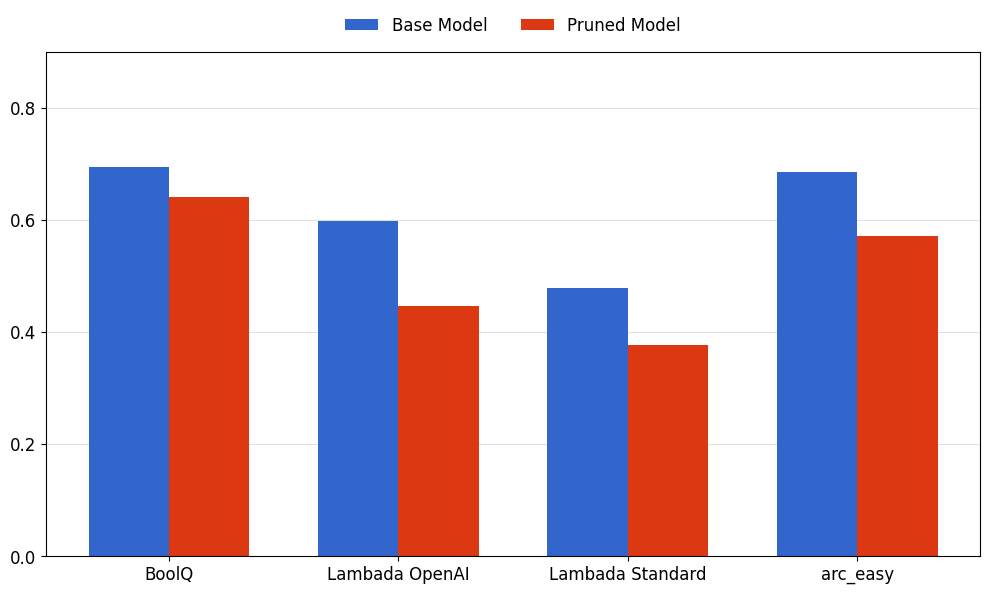

In [30]:
plot_model_comparison(metrics_base, metrics_pruned)

# Conclusion
This notebook serves as a demonstration of how simple it can be to create your own optimized models using the [OptiPFair](https://github.com/peremartra/optipfair/tree/main) library.

The result is a model that uses less memory and is faster at inference than the original, while still retaining most of its knowledge.

Of course, many more tests and a wider range of rankings are needed to fully understand the model’s performance. The evaluation module of the [OptiPFair](https://github.com/peremartra/optipfair/tree/main) library is still under development, so in the future it will be possible to apply more types of pruning and evaluate the resulting models with better benchmarks.

##Authors Note.
In addition to creating content like this notebook and offering it under the MIT license, I have also contributed to repositories such as those of Hugging Face and Google Gemini.

I am especially proud of my book: <a href="https://hubs.la/Q040tvsK0"><b>Rearchitecting LLMs - Structural techniques for efficient models</b></a> (Manning Publications).

You can find it at Manning.

If you take a look and end up purchasing it, keep in mind that you can reach out with any questions via the Discussions section of this same repository or on any of my social media channels. I’ll do my best to respond as quickly as possible.